In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
# N_up = 2
# nb_dir = '/'.join(os.getcwd().split('/')[:-N_up])
# if nb_dir not in sys.path:
#     sys.path.append(nb_dir)

N_up = 1
nb_dir = '/'.join(os.getcwd().split('/')[:-N_up])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    print(nb_dir)
    
    

/scratch4/ja666/dip_bayesian_ext


In [2]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [3]:
import jax

## Define utility functions

In [23]:

import numpy as np
import os
from omegaconf import DictConfig
import odl
import torch



In [24]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from odl.contrib.torch import OperatorModule


mnist_path = '/scratch4/ja666/dip_bayesian_ext/mnist'

def load_testset_MNIST_dataset(mnist_path, batchsize=1,
                               crop=False):
    
    testset = datasets.MNIST(root=mnist_path, train=False, download=True,
                             transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(
                                (0.1307,), (0.3081,))]))
    return DataLoader(testset, batchsize, shuffle=False)



def get_standard_ray_trafos(size=28, num_angles=5, return_torch_module=True):

    half_size = size / 2
    space = odl.uniform_discr([-half_size, -half_size], [half_size,
                              half_size], [size, size],
                              dtype='float32')
    geometry = odl.tomo.parallel_beam_geometry(space,
            num_angles=num_angles)
    ray_trafo = odl.tomo.RayTransform(space, geometry)
    pseudoinverse = odl.tomo.fbp_op(ray_trafo)
    if return_torch_module:
        ray_trafo = OperatorModule(ray_trafo)
        pseudoinverse = OperatorModule(pseudoinverse)

    return {
        'space': space,
        'geometry': geometry,
        'ray_trafo': ray_trafo,
        'pseudoinverse': pseudoinverse,
        }




def simulate(x, ray_trafos, noise_std):

    obs = ray_trafos['ray_trafo'](x)  # this is the transform
    relative_stddev = torch.mean(torch.abs(obs))
    observation = obs + torch.zeros(*obs.shape).normal_(0, 1) \
        * relative_stddev * noise_std
    filtbackproj = ray_trafos['pseudoinverse'](observation)
    return (observation, filtbackproj, x)




## basic projection and reconstruction

In [25]:
num_angles = 5
noise_std = 0.05

In [26]:
mnist_loader = load_testset_MNIST_dataset(mnist_path)
ray_trafos = get_standard_ray_trafos(size=28, num_angles=num_angles, return_torch_module=True)

examples = enumerate(mnist_loader)
batchsize, (example_image, example_targets) = next(examples)
observation, filtbackproj, example_image = simulate(example_image, ray_trafos, noise_std)




/var/home/ja666/.local/lib/python3.6/site-packages/odl/tomo/backends/skimage_radon.py:161: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  circle=False,


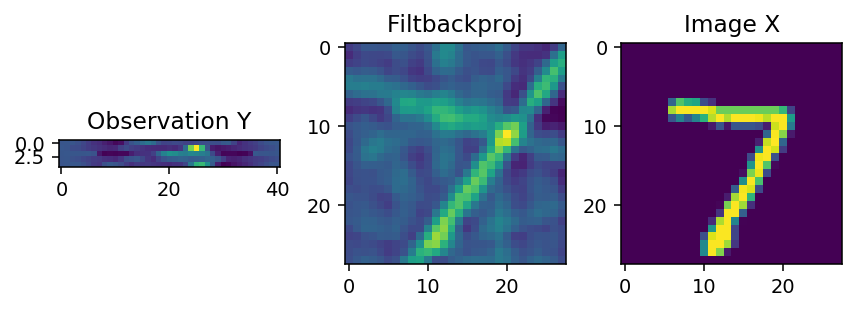

In [28]:
# simple viz.
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(6, 6),  facecolor='w', edgecolor='k', constrained_layout=True, dpi=140)
axs = axs.flatten()
axs[0].imshow(observation[0, 0].numpy())
axs[0].set_title('Observation Y')
axs[1].imshow(filtbackproj[0, 0].numpy())
axs[1].set_title('Filtbackproj')
axs[2].imshow(example_image[0, 0].numpy())
axs[2].set_title('Image X')
plt.show()

## matrix based projection and reconstruction
* Where does 41 come from?

In [36]:
image_np = example_image.numpy() 


ray_trafos = get_standard_ray_trafos(size=28, num_angles=num_angles, return_torch_module=False)
op_tensor = odl.operator.oputils.matrix_representation(ray_trafos['ray_trafo'])


op_mat = np.reshape(op_tensor, (num_angles*41, 28**2))

observation = op_mat @ image_np.flatten()



observation_mat = np.reshape(observation, (num_angles, 41))

op_mat_adj = op_mat.T

filtbackproj = op_mat_adj @ observation
filtbackproj_mat = np.reshape(filtbackproj, (28, 28))



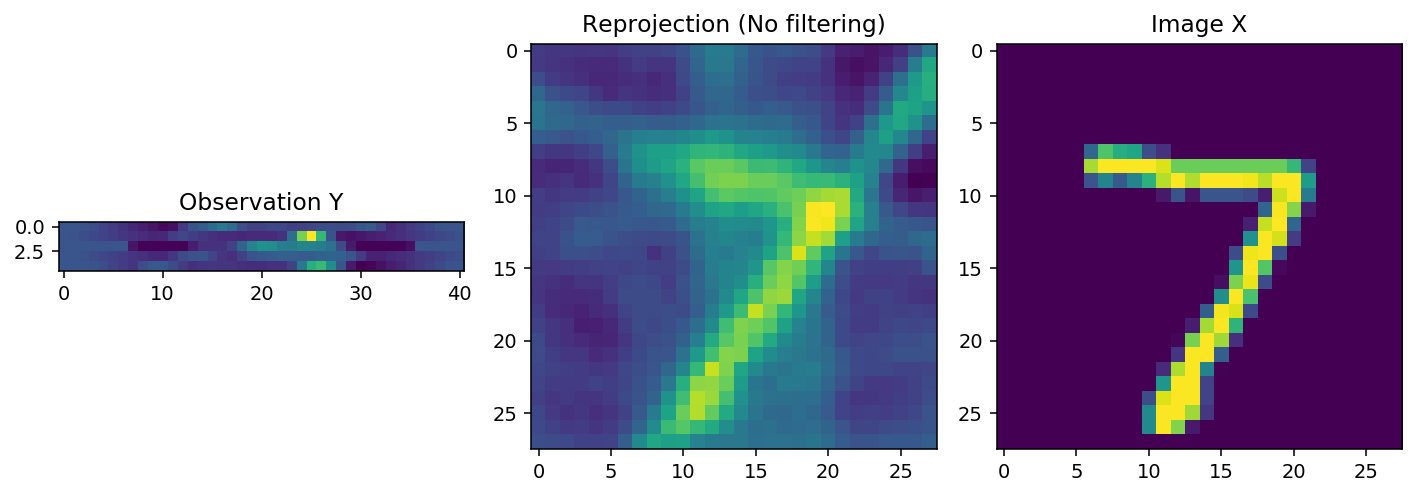

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10),  facecolor='w', edgecolor='k', constrained_layout=True, dpi=140)
axs = axs.flatten()
axs[0].imshow(observation_mat)
axs[0].set_title('Observation Y')
axs[1].imshow(filtbackproj_mat)
axs[1].set_title('Reprojection (No filtering)')
axs[2].imshow(example_image[0, 0].numpy())
axs[2].set_title('Image X')
plt.savefig('./images/reprojection.pdf')
plt.show()

In [94]:
example_image.std()

tensor(0.8403)

# define probabilistic models

In [111]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
from jax import jit

assert numpyro.__version__.startswith("0.8.0")

In [ ]:
def TV(x):
    h_tv = jnp.abs(jnp.diff(x, axis=-1, n=1)).sum()
    v_tv = jnp.abs(jnp.diff(x, axis=-2, n=1)).sum()
    return h_tv + v_tv




In [63]:
y = np.asarray(observation)
projector = np.asarray(op_mat)

print('y', y.shape, 'projector', projector.shape)

y (205,) projector (205, 784)


## sampling models

In [ ]:

def direct_model_normal_prior(y, projector):
    
    obs_dim = projector.shape[0]
    full_dim = projector.shape[1]
    
    
    x = numpyro.sample("x", dist.Normal(jnp.zeros((full_dim)), 0.8*jnp.ones((full_dim))))
    
    mu = projector @ x
    numpyro.sample(name="obs", fn=dist.Normal(mu, jnp.ones(obs_dim)), obs=y)
    
    
def direct_model_tv_prior(y, projector):
    
    obs_dim = projector.shape[0]
    full_dim = projector.shape[1]
    
    
    x = numpyro.sample("x", dist.Normal(jnp.zeros((full_dim)), 10*jnp.ones((full_dim))))
    
    tv = TV(x.reshape(28,28))
    numpyro.sample(name="tv_prior", fn=dist.Exponential(10), obs=tv)
    
#     sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    
    mu = projector @ x
    numpyro.sample(name="obs", fn=dist.Normal(mu, jnp.ones(obs_dim)), obs=y)



## MLE models

In [141]:
from jax.scipy.stats import norm  #, poisson, bernoulli

@jit
def gaussian_ll(y, mu, log_std):
    std = jnp.exp(log_std)
    z = (y-mu)
    return norm.logpdf(z, loc=0, scale=std)


def gen_direct_TV_MLE_objective(y, lam, projector):
    
    def direct_TV_MLE_objective(params):
        
        x = params['x']
        tv = TV(x.reshape(28,28))
        y_pred = projector @ x
        return gaussian_ll(y, y_pred, 0).sum(axis=0) - lam * tv
    
    return jit(direct_TV_MLE_objective)
    
    
    
    





In [151]:
from jax.experimental import optimizers
from jax import value_and_grad
from jax.tree_util import tree_map



params = {}
params['x'] = jnp.zeros(784)

lam = 1
    
objective = gen_direct_TV_MLE_objective(y, lam, projector)

obj_grad = jit(value_and_grad(objective))


@jit
def update(params, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = obj_grad(params)
    grads_norm = tree_map(lambda x: -x/x.shape[0], grads)
    opt_state = opt_update(0, grads_norm, opt_state)
    return get_params(opt_state), opt_state, value

step_size = 1e-2
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)




In [152]:

%%time 

for i in range(10000):
    params, opt_state, LL = update(params, opt_state)
    
    if i % 100 == 0:
        print(i, LL)

0 -4754.349609375
100 -481.7763671875
200 -449.268798828125
300 -437.9016418457031
400 -430.4603271484375
500 -424.9786682128906
600 -420.663818359375
700 -417.176513671875
800 -414.28143310546875
900 -411.8594970703125
1000 -409.7584228515625
1100 -408.02215576171875
1200 -406.526611328125
1300 -405.3202819824219
1400 -404.2541198730469
1500 -403.4175720214844
1600 -402.6628723144531
1700 -402.0084228515625
1800 -401.4059143066406
1900 -400.8785095214844
2000 -400.3828125
2100 -399.9830322265625
2200 -399.66265869140625
2300 -399.39251708984375
2400 -399.14202880859375
2500 -398.9669189453125
2600 -398.79425048828125
2700 -398.6753845214844
2800 -398.5611267089844
2900 -398.4832763671875
3000 -398.41754150390625
3100 -398.35693359375
3200 -398.2930908203125
3300 -398.2526550292969
3400 -398.23785400390625
3500 -398.22760009765625
3600 -398.2086486816406
3700 -398.189208984375
3800 -398.1578369140625
3900 -398.13134765625
4000 -398.1282653808594
4100 -398.1575927734375
4200 -398.152465

Text(0.5, 1.0, 'MAP solution with TV regulariser')

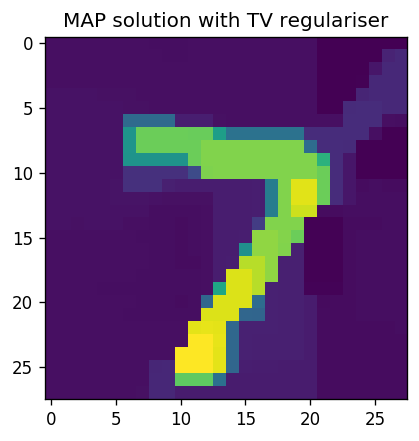

In [153]:
plt.figure(dpi=120)
plt.imshow(params['x'].reshape(28,28))
plt.title('MAP solution with TV regulariser')


## run MCMC inference

In [ ]:
nuts_kernel_normal = NUTS(direct_model_normal_prior)
mcmc = MCMC(nuts_kernel_normal, num_warmup=1000, num_samples=2000)
rng_key = random.PRNGKey(0)

mcmc.run(
    rng_key,
    y=y,
    projector=projector
)
mcmc.print_summary()
normal_samples = mcmc.get_samples()

In [ ]:



nuts_kernel_tv = NUTS(direct_model_tv_prior)
mcmc = MCMC(nuts_kernel_tv, num_warmup=1000, num_samples=2000)
rng_key = random.PRNGKey(0)

mcmc.run(
    rng_key,
    y=y,
    projector=projector
)
mcmc.print_summary()
tv_samples = mcmc.get_samples()



## visualizations

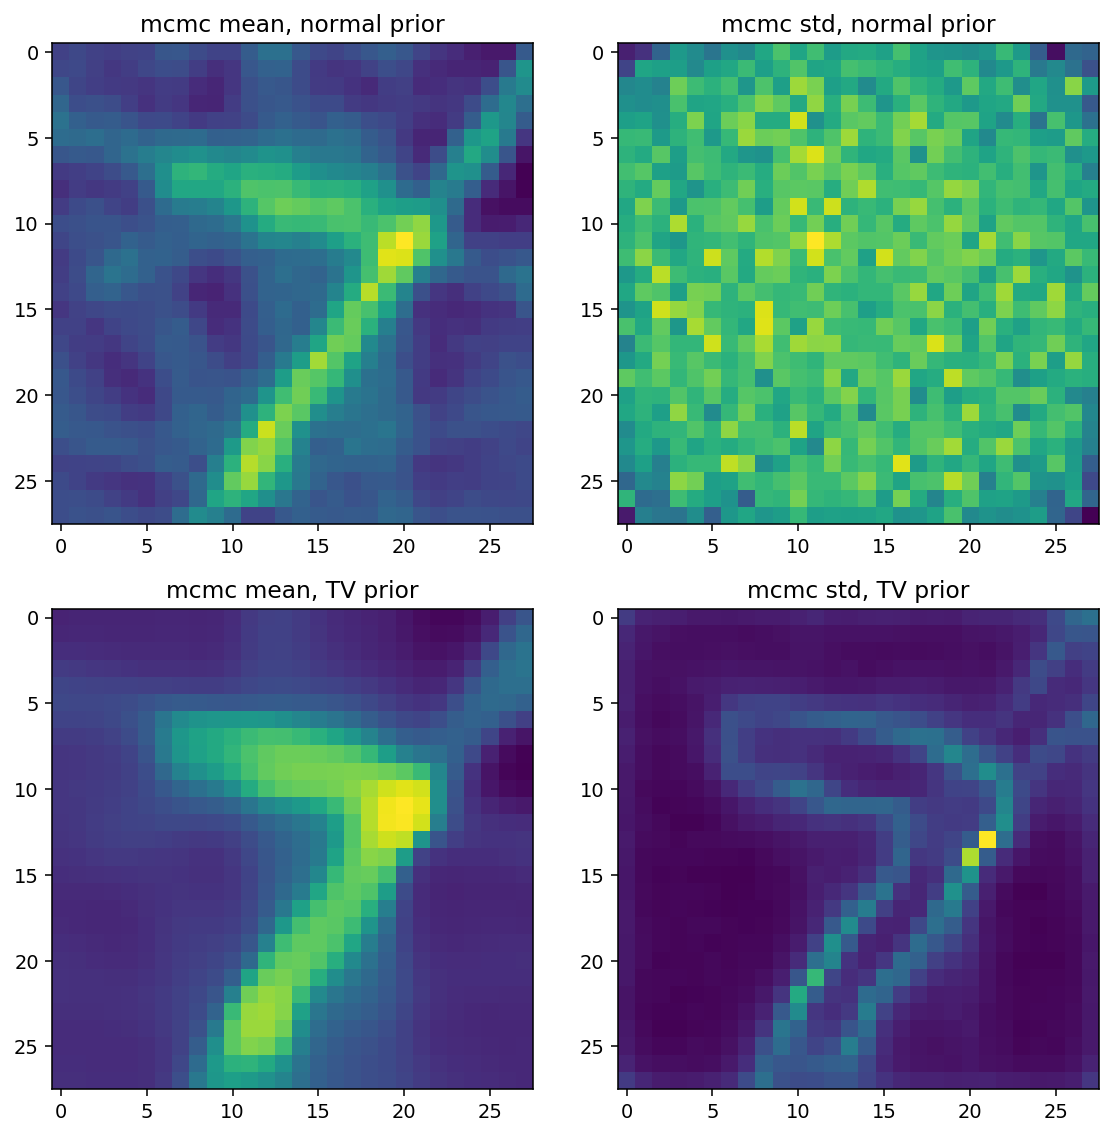

In [108]:


reconstruction_mean_normal = normal_samples['x'].mean(axis=0).reshape(28,28)
reconstruction_std_normal = normal_samples['x'].std(axis=0).reshape(28,28)

reconstruction_mean_tv = tv_samples['x'].mean(axis=0).reshape(28,28)
reconstruction_std_tv = tv_samples['x'].std(axis=0).reshape(28,28)

fig, axs = plt.subplots(2, 2, figsize=(8, 8),  facecolor='w', edgecolor='k', constrained_layout=True, dpi=140)
axs = axs.flatten()
axs[0].imshow(reconstruction_mean_normal)
axs[0].set_title('mcmc mean, normal prior')
axs[1].imshow(reconstruction_std_normal)
axs[1].set_title('mcmc std, normal prior')
axs[2].imshow(reconstruction_mean_tv)
axs[2].set_title('mcmc mean, TV prior')
axs[3].imshow(reconstruction_std_tv)
axs[3].set_title('mcmc std, TV prior')
plt.savefig('./images/prior_comparison.pdf') # diag_input_g15
plt.show()
